<a href="https://colab.research.google.com/github/Rakib911Hossan/Emotion_Detection-AI_Project/blob/main/Emotion__Detection_Ensemble_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""
Complete Emotion Classification Pipeline
Production-ready notebook for emotion detection from text
"""

# ============================================================================
# SECTION 0: SETUP & INSTALLATIONS
# ============================================================================

# Install required packages
!pip install neattext wordcloud imbalanced-learn xgboost tqdm -q

# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from collections import Counter
import joblib

# Preprocessing & NLP
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, classification_report, confusion_matrix,
                            roc_curve, auc, roc_auc_score)

# Imbalanced data handling
from imblearn.over_sampling import SMOTE

# Visualization
from wordcloud import WordCloud

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All packages imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 6.1 MB/s eta 0:00:00
✓ All packages imported successfully!


In [ ]:
# ============================================================================
# SECTION 1: DATA LOADING & BASIC EDA
# ============================================================================

# Upload file (for Colab)
from google.colab import files
print("Please upload your emotion_dataset_raw.csv file:")
uploaded = files.upload()

# Load dataset
df = pd.read_csv('emotion_dataset_raw.csv')

print("\n" + "="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nDataset Shape: {df.shape}")
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

print("\n--- First 5 rows ---")
display(df.head())

# Check if Clean_Text exists, if not create it
if 'Clean_Text' not in df.columns:
    print("\n⚠️  'Clean_Text' column not found. Creating cleaned text...")
    import neattext.functions as nfx

    # Create Clean_Text by removing userhandles and stopwords
    df['Clean_Text'] = df['Text'].apply(nfx.remove_userhandles)
    df['Clean_Text'] = df['Clean_Text'].apply(nfx.remove_stopwords)
    print("✓ Clean_Text column created successfully!")
else:
    print("\n✓ Clean_Text column found in dataset")

print("\n--- Dataset Info ---")
print(df.info())

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Data Types ---")
print(df.dtypes)

print("\n--- Basic Statistics ---")
display(df.describe())


Please upload your emotion_dataset_raw.csv file:


Saving emotion_dataset_raw.csv to emotion_dataset_raw.csv

DATASET OVERVIEW

Dataset Shape: (34792, 2)
Number of samples: 34792
Number of features: 2

--- First 5 rows ---


,Emotion,Text
0,neutral,Why ?
1,joy,Sage Act upgrade on my to do list for tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...



⚠️  'Clean_Text' column not found. Creating cleaned text...
✓ Clean_Text column created successfully!

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34792 entries, 0 to 34791
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Emotion     34792 non-null  object
 1   Text        34792 non-null  object
 2   Clean_Text  34792 non-null  object
dtypes: object(3)
memory usage: 815.6+ KB
None

--- Missing Values ---
Emotion       0
Text          0
Clean_Text    0
dtype: int64

--- Data Types ---
Emotion       object
Text          object
Clean_Text    object
dtype: object

--- Basic Statistics ---


,Emotion,Text,Clean_Text
count,34792,34792,34792
unique,8,31110,30747
top,joy,Yes .,?
freq,11045,76,292



EMOTION CLASS DISTRIBUTION

Emotion Counts:
Emotion
joy         11045
sadness      6722
fear         5410
anger        4297
surprise     4062
neutral      2254
disgust       856
shame         146
Name: count, dtype: int64

Total unique emotions: 8


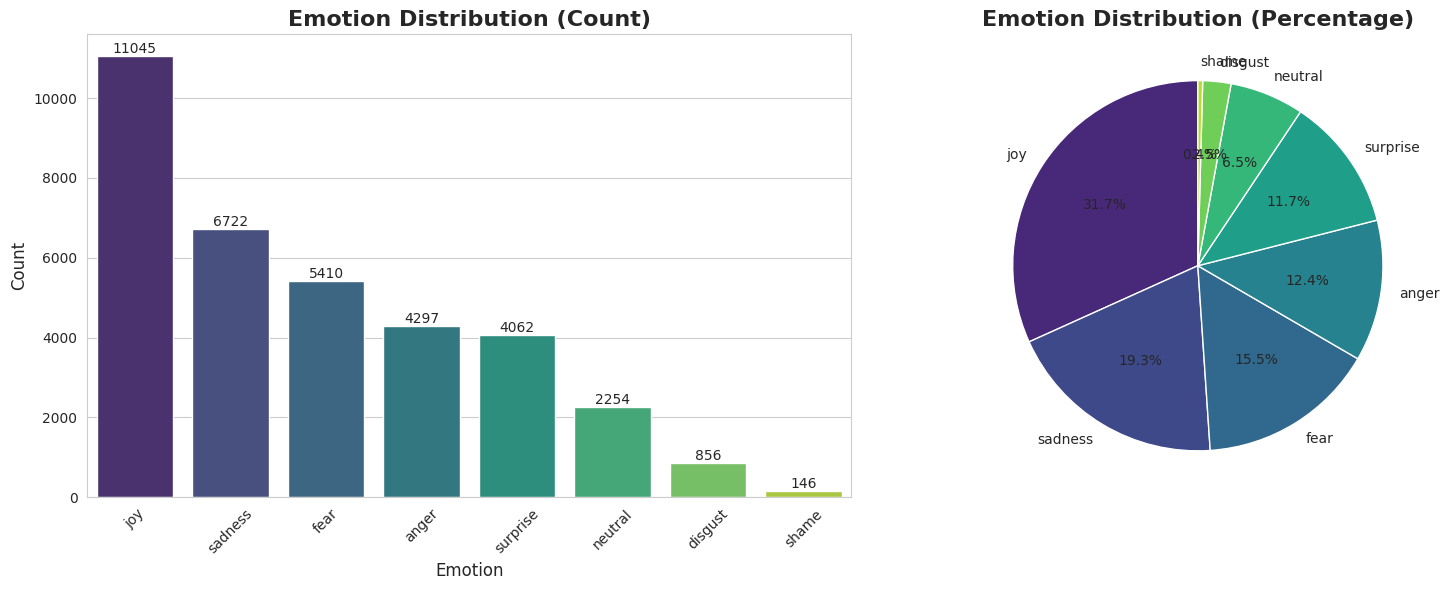


--- Class Imbalance Analysis ---
Imbalance Ratio (max/min): 75.65
⚠️  Significant class imbalance detected! SMOTE will be applied.

TEXT LENGTH ANALYSIS

--- Text Length Statistics ---
        Text_Length  Clean_Text_Length    Word_Count
count  34792.000000       34792.000000  34792.000000
mean      86.696166          53.431593      8.470223
std       47.439640          30.181976      4.561478
min        4.000000           0.000000      0.000000
25%       54.000000          32.000000      5.000000
50%       83.000000          50.000000      8.000000
75%      116.000000          71.000000     11.000000
max     1160.000000         592.000000    112.000000

--- Average Metrics by Emotion ---


,Text_Length,Clean_Text_Length,Word_Count
Emotion,,,
anger,99.96,58.55,9.26
disgust,92.48,58.07,9.03
fear,100.61,61.40,9.43
joy,84.70,53.68,8.32
neutral,31.10,16.12,3.80
sadness,87.78,52.20,8.38
shame,105.09,62.29,10.03
surprise,86.74,58.17,9.35


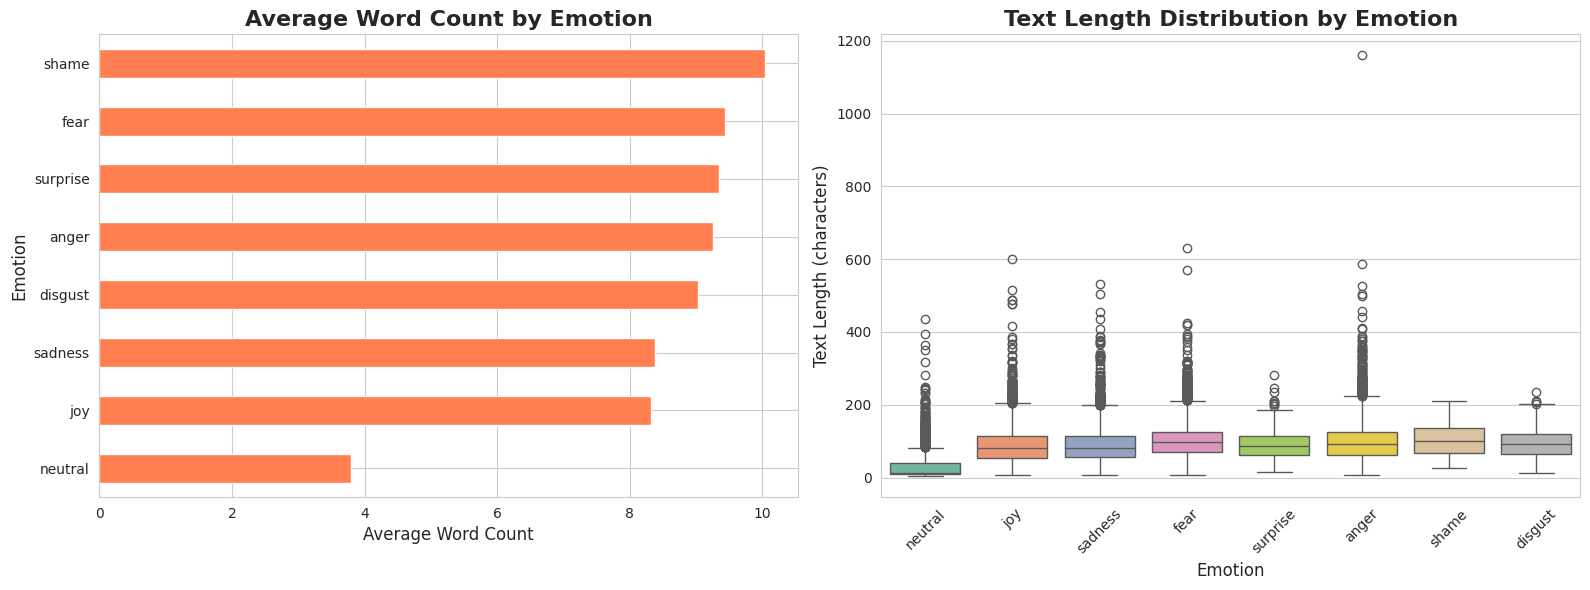

In [ ]:
# ============================================================================
# SECTION 2: EMOTION DISTRIBUTION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("EMOTION CLASS DISTRIBUTION")
print("="*80)

emotion_counts = df['Emotion'].value_counts()
print("\nEmotion Counts:")
print(emotion_counts)
print(f"\nTotal unique emotions: {df['Emotion'].nunique()}")

# Plot emotion distribution
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Count plot
sns.countplot(data=df, x='Emotion', order=emotion_counts.index, palette='viridis', ax=ax[0])
ax[0].set_title('Emotion Distribution (Count)', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Emotion', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].tick_params(axis='x', rotation=45)

# Add count labels on bars
for container in ax[0].containers:
    ax[0].bar_label(container)

# Pie chart
colors = sns.color_palette('viridis', len(emotion_counts))
ax[1].pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%',
          colors=colors, startangle=90)
ax[1].set_title('Emotion Distribution (Percentage)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

# Check class imbalance
print("\n--- Class Imbalance Analysis ---")
imbalance_ratio = emotion_counts.max() / emotion_counts.min()
print(f"Imbalance Ratio (max/min): {imbalance_ratio:.2f}")
if imbalance_ratio > 3:
    print("⚠️  Significant class imbalance detected! SMOTE will be applied.")
else:
    print("✓ Classes are relatively balanced.")

# ============================================================================
# SECTION 3: TEXT LENGTH ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("TEXT LENGTH ANALYSIS")
print("="*80)

# Calculate text lengths
df['Text_Length'] = df['Text'].apply(len)
df['Clean_Text_Length'] = df['Clean_Text'].apply(len)
df['Word_Count'] = df['Clean_Text'].apply(lambda x: len(str(x).split()))

print("\n--- Text Length Statistics ---")
print(df[['Text_Length', 'Clean_Text_Length', 'Word_Count']].describe())

# Average text length by emotion
avg_length_by_emotion = df.groupby('Emotion').agg({
    'Text_Length': 'mean',
    'Clean_Text_Length': 'mean',
    'Word_Count': 'mean'
}).round(2)

print("\n--- Average Metrics by Emotion ---")
display(avg_length_by_emotion)

# Plot average text length by emotion
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Word count
df.groupby('Emotion')['Word_Count'].mean().sort_values().plot(
    kind='barh', ax=ax[0], color='coral'
)
ax[0].set_title('Average Word Count by Emotion', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Average Word Count', fontsize=12)
ax[0].set_ylabel('Emotion', fontsize=12)

# Text length distribution
sns.boxplot(data=df, x='Emotion', y='Text_Length', palette='Set2', ax=ax[1])
ax[1].set_title('Text Length Distribution by Emotion', fontsize=16, fontweight='bold')
ax[1].set_xlabel('Emotion', fontsize=12)
ax[1].set_ylabel('Text Length (characters)', fontsize=12)
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



TOP 20 FREQUENT WORDS PER EMOTION

--- NEUTRAL ---
Word                 Frequency 
------------------------------
.                    1730      
?                    794       
,                    567       
!                    194       
’                    176       
Yes                  141       
Oh                   62        
think                58        
like                 54        
...                  50        

--- JOY ---
Word                 Frequency 
------------------------------
.                    2007      
,                    1365      
&amp;                675       
day                  580       
I'm                  522       
time                 488       
like                 465       
Christmas            409       
work                 396       
love                 356       

--- SADNESS ---
Word                 Frequency 
------------------------------
.                    2240      
,                    1412      
I'm                  465 

Generating word clouds: 100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


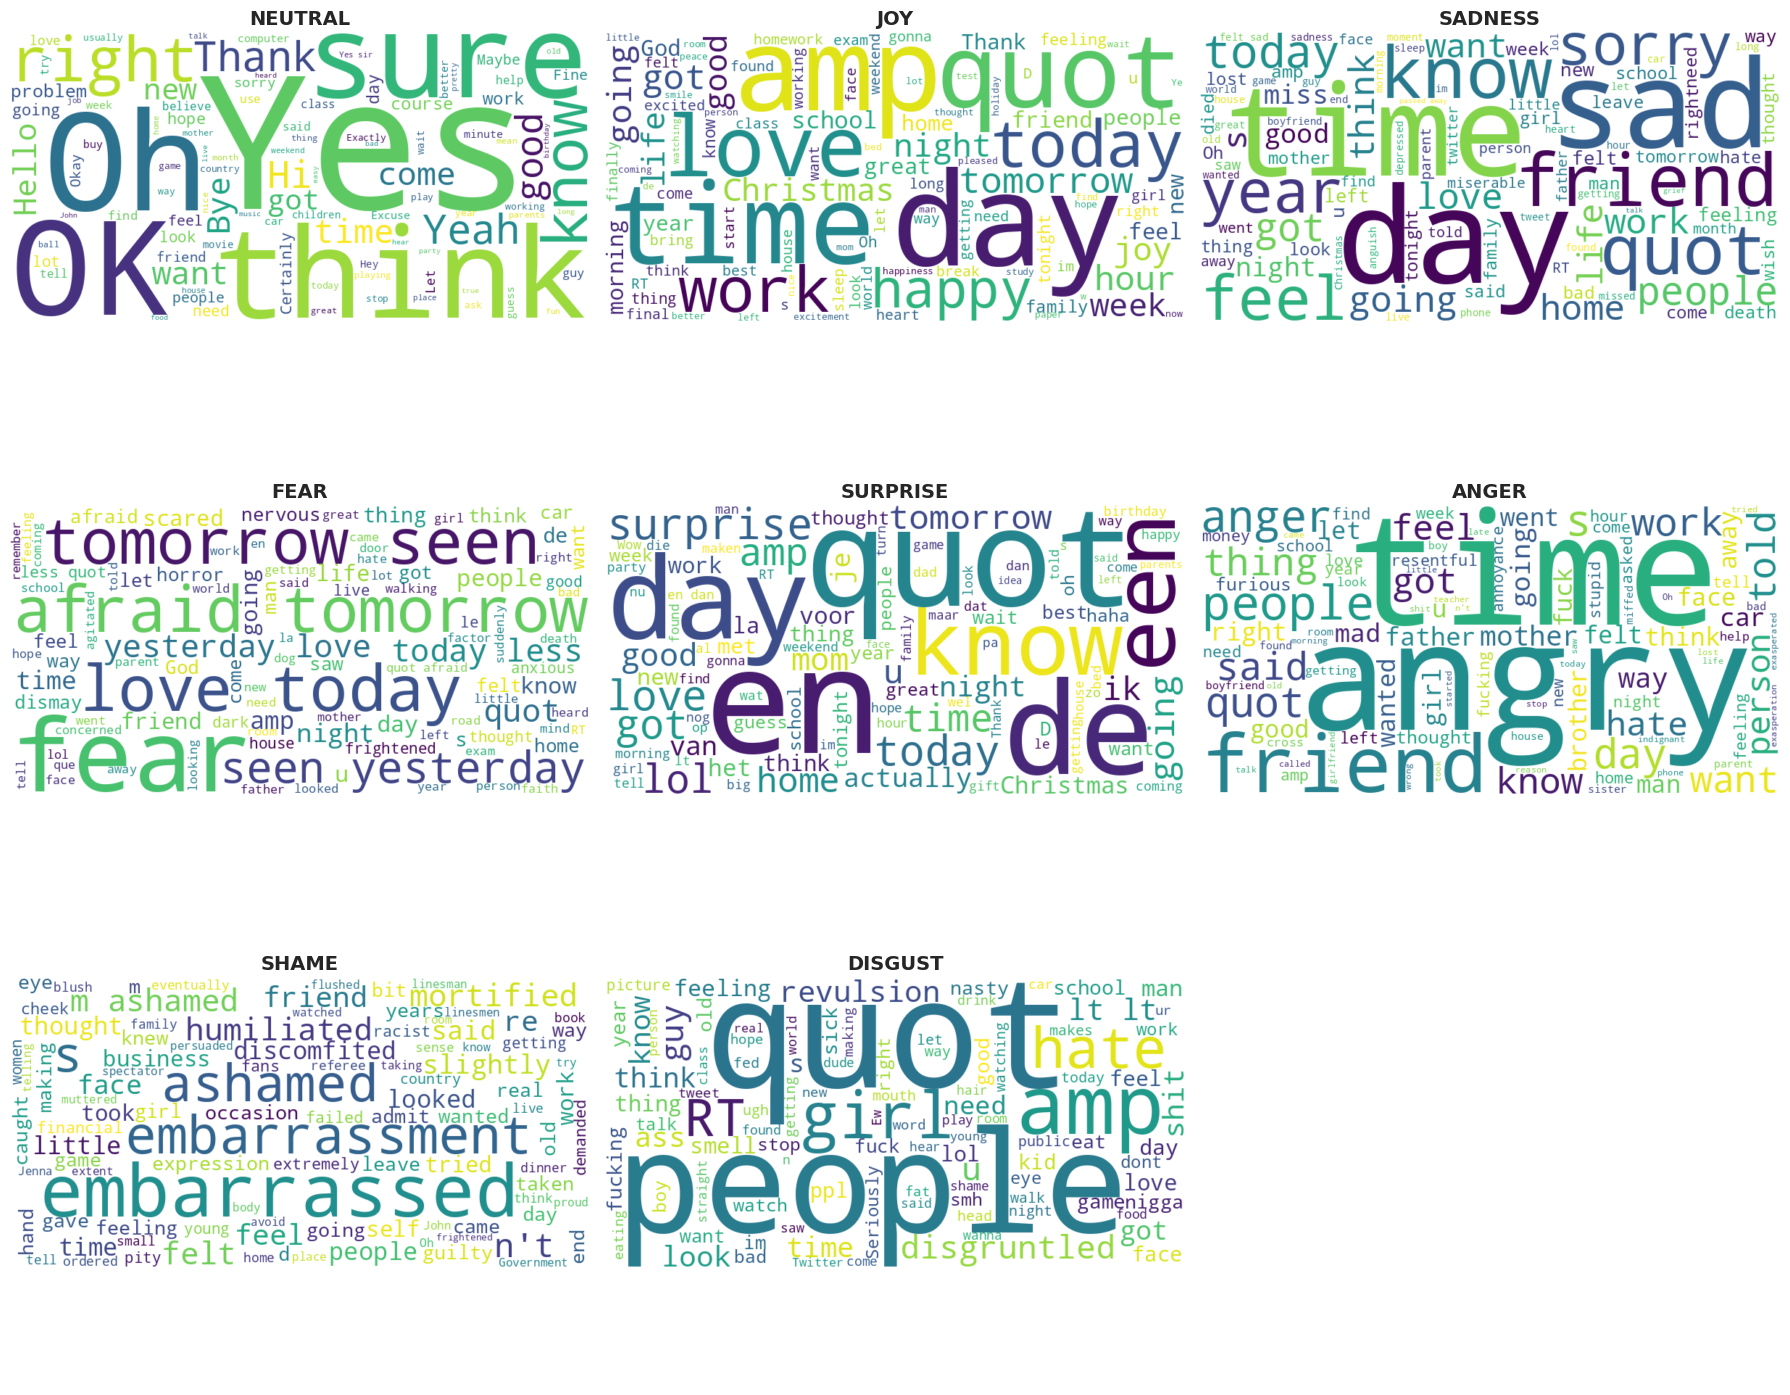

In [ ]:
# ============================================================================
# SECTION 4: TOP FREQUENT WORDS PER EMOTION
# ============================================================================

print("\n" + "="*80)
print("TOP 20 FREQUENT WORDS PER EMOTION")
print("="*80)

def get_top_words(text_series, n=20):
    """Extract top N most frequent words from text series"""
    all_words = ' '.join(text_series.astype(str)).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

# Get top words for each emotion
for emotion in df['Emotion'].unique():
    emotion_texts = df[df['Emotion'] == emotion]['Clean_Text']
    top_words = get_top_words(emotion_texts, n=20)

    print(f"\n--- {emotion.upper()} ---")
    print(f"{'Word':<20} {'Frequency':<10}")
    print("-" * 30)
    for word, freq in top_words[:10]:  # Show top 10 in console
        print(f"{word:<20} {freq:<10}")

# ============================================================================
# SECTION 5: WORD CLOUDS PER EMOTION
# ============================================================================

print("\n" + "="*80)
print("GENERATING WORD CLOUDS FOR EACH EMOTION")
print("="*80)

emotions = df['Emotion'].unique()
n_emotions = len(emotions)

# Calculate grid dimensions
n_cols = 3
n_rows = (n_emotions + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten() if n_emotions > 1 else [axes]

for idx, emotion in enumerate(tqdm(emotions, desc="Generating word clouds")):
    emotion_text = ' '.join(df[df['Emotion'] == emotion]['Clean_Text'].astype(str))

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate(emotion_text)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f'{emotion.upper()}', fontsize=14, fontweight='bold')

# Hide unused subplots
for idx in range(n_emotions, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# SECTION 6: DATA PREPROCESSING
# ============================================================================

print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80)

# Prepare features and labels
X = df['Clean_Text']
y = df['Emotion']

print(f"\nOriginal dataset size: {len(X)}")
print(f"Unique emotions: {y.nunique()}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("\n--- Label Encoding ---")
for i, emotion in enumerate(label_encoder.classes_):
    print(f"{emotion}: {i}")

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\n✓ Train set size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"✓ Test set size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# TF-IDF Vectorization
print("\n--- TF-IDF Vectorization ---")
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    min_df=2,
    max_df=0.9
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"✓ TF-IDF matrix shape (train): {X_train_tfidf.shape}")
print(f"✓ TF-IDF matrix shape (test): {X_test_tfidf.shape}")
print(f"✓ Vocabulary size: {len(tfidf.vocabulary_)}")

# Apply SMOTE for class imbalance
print("\n--- Applying SMOTE for Class Imbalance ---")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

print(f"✓ Original training size: {X_train_tfidf.shape[0]}")
print(f"✓ Balanced training size: {X_train_balanced.shape[0]}")
print(f"\nClass distribution after SMOTE:")
unique, counts = np.unique(y_train_balanced, return_counts=True)
for emotion_idx, count in zip(unique, counts):
    print(f"  {label_encoder.classes_[emotion_idx]}: {count}")

# ============================================================================
# SECTION 7: MODEL TRAINING - INDIVIDUAL MODELS
# ============================================================================

print("\n" + "="*80)
print("TRAINING INDIVIDUAL MODELS")
print("="*80)

# Dictionary to store models and results
models = {}
results = []

# 1. Logistic Regression
print("\n[1/4] Training Logistic Regression...")
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)
lr_model.fit(X_train_balanced, y_train_balanced)
models['Logistic Regression'] = lr_model
print("✓ Logistic Regression trained")

# 2. Linear SVM
print("\n[2/4] Training Linear SVM...")
svm_model = LinearSVC(
    class_weight='balanced',
    max_iter=2000,
    random_state=42
)
svm_model.fit(X_train_balanced, y_train_balanced)
models['Linear SVM'] = svm_model
print("✓ Linear SVM trained")

# 3. Random Forest
print("\n[3/4] Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_balanced, y_train_balanced)
models['Random Forest'] = rf_model
print("✓ Random Forest trained")

# 4. XGBoost
print("\n[4/4] Training XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train_balanced, y_train_balanced)
models['XGBoost'] = xgb_model
print("✓ XGBoost trained")


DATA PREPROCESSING

Original dataset size: 34792
Unique emotions: 8

--- Label Encoding ---
anger: 0
disgust: 1
fear: 2
joy: 3
neutral: 4
sadness: 5
shame: 6
surprise: 7

✓ Train set size: 27833 (80.0%)
✓ Test set size: 6959 (20.0%)

--- TF-IDF Vectorization ---
✓ TF-IDF matrix shape (train): (27833, 5000)
✓ TF-IDF matrix shape (test): (6959, 5000)
✓ Vocabulary size: 5000

--- Applying SMOTE for Class Imbalance ---
✓ Original training size: 27833
✓ Balanced training size: 70688

Class distribution after SMOTE:
  anger: 8836
  disgust: 8836
  fear: 8836
  joy: 8836
  neutral: 8836
  sadness: 8836
  shame: 8836
  surprise: 8836

TRAINING INDIVIDUAL MODELS

[1/4] Training Logistic Regression...
✓ Logistic Regression trained

[2/4] Training Linear SVM...
✓ Linear SVM trained

[3/4] Training Random Forest...
✓ Random Forest trained

[4/4] Training XGBoost...
✓ XGBoost trained



EVALUATING INDIVIDUAL MODELS


Evaluating models: 100%|██████████| 4/4 [17:54<00:00, 268.72s/it]


--- Model Performance Comparison ---


,Model,Accuracy,Precision,Recall,F1-Score,CV Mean F1,CV Std F1
0,Logistic Regression,0.5928,0.6125,0.5928,0.5992,0.7415,0.0044
1,Linear SVM,0.5841,0.6018,0.5841,0.5898,0.7722,0.0051
2,Random Forest,0.5807,0.5910,0.5807,0.5774,0.8584,0.0200
3,XGBoost,0.5120,0.6223,0.5120,0.5363,0.6644,0.0215


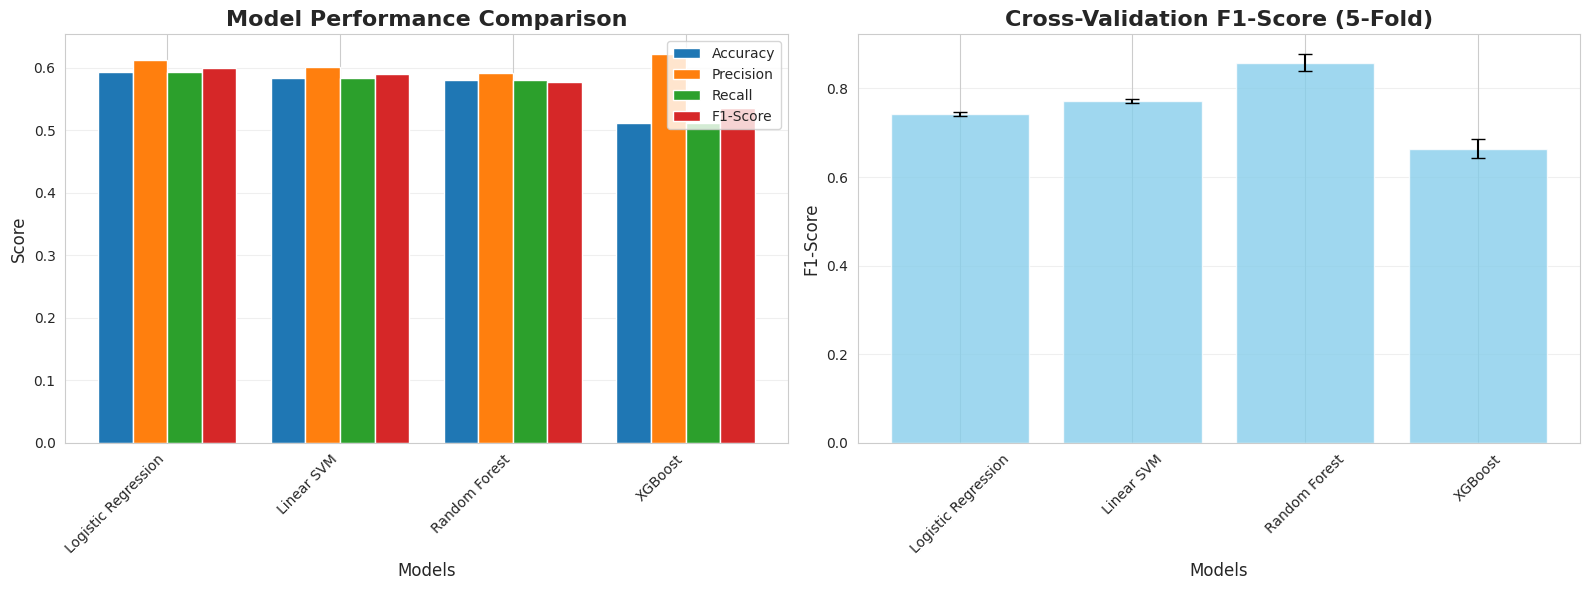


TRAINING ENSEMBLE MODELS

[1/2] Training Voting Classifier (Hard Voting)...
✓ Voting Classifier trained

[2/2] Training Stacking Classifier...
✓ Stacking Classifier trained

--- Ensemble Model Performance ---


,Model,Accuracy,Precision,Recall,F1-Score
0,Voting Classifier,0.6058,0.6216,0.6058,0.6073
1,Stacking Classifier,0.6162,0.6291,0.6162,0.6078



--- All Models Performance (Ranked by F1-Score) ---


,Model,Accuracy,Precision,Recall,F1-Score
5,Stacking Classifier,0.6162,0.6291,0.6162,0.6078
4,Voting Classifier,0.6058,0.6216,0.6058,0.6073
0,Logistic Regression,0.5928,0.6125,0.5928,0.5992
1,Linear SVM,0.5841,0.6018,0.5841,0.5898
2,Random Forest,0.5807,0.5910,0.5807,0.5774
3,XGBoost,0.5120,0.6223,0.5120,0.5363


In [ ]:
# ============================================================================
# SECTION 8: MODEL EVALUATION - INDIVIDUAL MODELS
# ============================================================================

print("\n" + "="*80)
print("EVALUATING INDIVIDUAL MODELS")
print("="*80)

# Evaluate each model
for name, model in tqdm(models.items(), desc="Evaluating models"):
    # Predictions
    y_pred = model.predict(X_test_tfidf)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Cross-validation
    cv_scores = cross_val_score(
        model, X_train_balanced, y_train_balanced,
        cv=5, scoring='f1_weighted', n_jobs=-1
    )

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'CV Mean F1': cv_scores.mean(),
        'CV Std F1': cv_scores.std()
    })

# Results DataFrame
results_df = pd.DataFrame(results).sort_values('F1-Score', ascending=False)
print("\n--- Model Performance Comparison ---")
display(results_df.round(4))

# Visualize results
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics):
    ax[0].bar(x + i*width, results_df[metric], width, label=metric)

ax[0].set_xlabel('Models', fontsize=12)
ax[0].set_ylabel('Score', fontsize=12)
ax[0].set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
ax[0].set_xticks(x + width * 1.5)
ax[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax[0].legend()
ax[0].grid(axis='y', alpha=0.3)

# Cross-validation F1 scores
ax[1].bar(results_df['Model'], results_df['CV Mean F1'],
          yerr=results_df['CV Std F1'], capsize=5, color='skyblue', alpha=0.8)
ax[1].set_xlabel('Models', fontsize=12)
ax[1].set_ylabel('F1-Score', fontsize=12)
ax[1].set_title('Cross-Validation F1-Score (5-Fold)', fontsize=16, fontweight='bold')
ax[1].tick_params(axis='x', rotation=45)
ax[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# SECTION 9: ENSEMBLE MODELS
# ============================================================================

print("\n" + "="*80)
print("TRAINING ENSEMBLE MODELS")
print("="*80)

# Voting Classifier (Hard Voting)
print("\n[1/2] Training Voting Classifier (Hard Voting)...")
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('svm', svm_model),
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    voting='hard',
    n_jobs=-1
)
voting_clf.fit(X_train_balanced, y_train_balanced)
print("✓ Voting Classifier trained")

# Stacking Classifier
print("\n[2/2] Training Stacking Classifier...")
stacking_clf = StackingClassifier(
    estimators=[
        ('lr', lr_model),
        ('svm', svm_model),
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    final_estimator=XGBClassifier(random_state=42, eval_metric='mlogloss'),
    n_jobs=-1
)
stacking_clf.fit(X_train_balanced, y_train_balanced)
print("✓ Stacking Classifier trained")

# Add ensemble models to dictionary
models['Voting Classifier'] = voting_clf
models['Stacking Classifier'] = stacking_clf

# Evaluate ensemble models
ensemble_results = []

for name in ['Voting Classifier', 'Stacking Classifier']:
    model = models[name]
    y_pred = model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    ensemble_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

ensemble_df = pd.DataFrame(ensemble_results)
print("\n--- Ensemble Model Performance ---")
display(ensemble_df.round(4))

# Combined results
all_results_df = pd.concat([results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']],
                            ensemble_df], ignore_index=True).sort_values('F1-Score', ascending=False)

print("\n--- All Models Performance (Ranked by F1-Score) ---")
display(all_results_df.round(4))


BEST MODEL DETAILED EVALUATION

🏆 Best Model: Stacking Classifier
   F1-Score: 0.6078

--- Classification Report ---
              precision    recall  f1-score   support

       anger     0.7002    0.5023    0.5850       860
     disgust     0.6981    0.2164    0.3304       171
        fear     0.7653    0.6479    0.7017      1082
         joy     0.5654    0.8022    0.6633      2209
     neutral     0.7282    0.6297    0.6754       451
     sadness     0.5801    0.5517    0.5655      1345
       shame     0.9130    0.7241    0.8077        29
    surprise     0.5466    0.3682    0.4400       812

    accuracy                         0.6162      6959
   macro avg     0.6871    0.5553    0.5961      6959
weighted avg     0.6291    0.6162    0.6078      6959



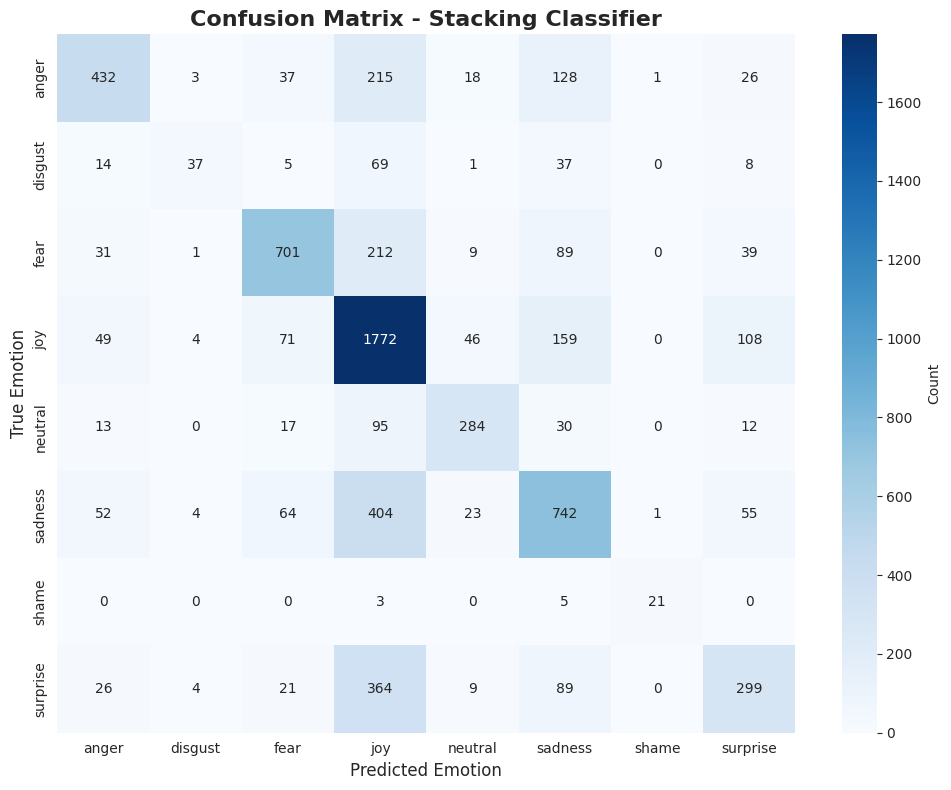


PLOTTING ROC CURVES


Generating ROC curves: 100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


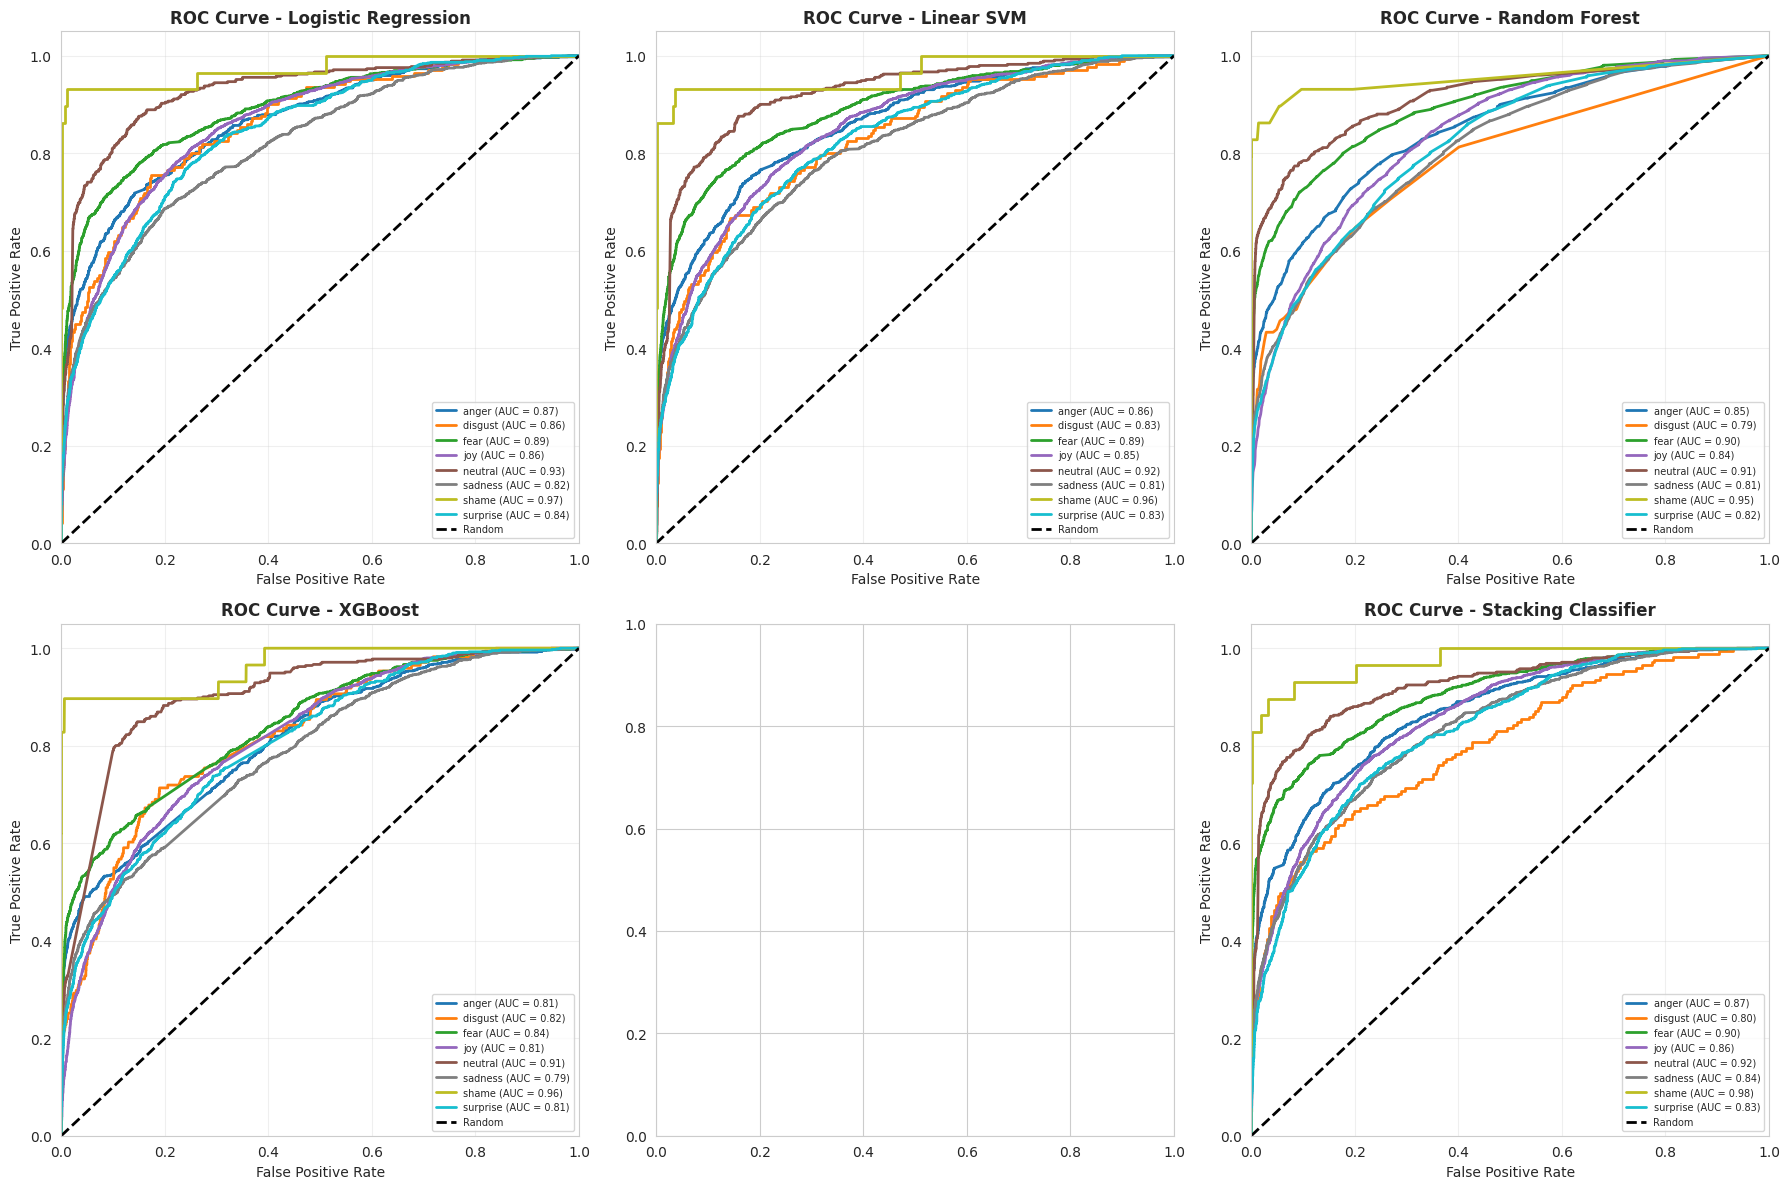

In [ ]:
# ============================================================================
# SECTION 10: BEST MODEL - DETAILED EVALUATION
# ============================================================================

print("\n" + "="*80)
print("BEST MODEL DETAILED EVALUATION")
print("="*80)

# Select best model
best_model_name = all_results_df.iloc[0]['Model']
best_model = models[best_model_name]
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   F1-Score: {all_results_df.iloc[0]['F1-Score']:.4f}")

# Predictions
y_pred_best = best_model.predict(X_test_tfidf)

# Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_best,
                          target_names=label_encoder.classes_,
                          digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
ax.set_xlabel('Predicted Emotion', fontsize=12)
ax.set_ylabel('True Emotion', fontsize=12)
plt.tight_layout()
plt.show()

# ============================================================================
# SECTION 11: ROC CURVES
# ============================================================================

print("\n" + "="*80)
print("PLOTTING ROC CURVES")
print("="*80)

from sklearn.preprocessing import label_binarize

# Binarize labels for ROC
y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
n_classes = y_test_bin.shape[1]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

model_names = list(models.keys())

for idx, name in enumerate(tqdm(model_names, desc="Generating ROC curves")):
    model = models[name]

    # Get prediction probabilities
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test_tfidf)
    elif hasattr(model, 'decision_function'):
        y_score = model.decision_function(X_test_tfidf)
        # Normalize decision function output
        from scipy.special import softmax
        y_score = softmax(y_score, axis=1) if len(y_score.shape) > 1 else y_score
    else:
        continue

    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot
    ax = axes[idx]
    colors = plt.cm.get_cmap('tab10', n_classes)

    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=10)
    ax.set_ylabel('True Positive Rate', fontsize=10)
    ax.set_title(f'ROC Curve - {name}', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=7)
    ax.grid(alpha=0.3)

# Hide unused subplot
if len(model_names) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# SECTION 12: MODEL SAVING
# ============================================================================

print("\n" + "="*80)
print("SAVING BEST MODEL")
print("="*80)

# Save model
model_filename = 'best_emotion_model.pkl'
joblib.dump(best_model, model_filename)
print(f"✓ Best model saved as: {model_filename}")

# Save TF-IDF vectorizer
tfidf_filename = 'tfidf_vectorizer.pkl'
joblib.dump(tfidf, tfidf_filename)
print(f"✓ TF-IDF vectorizer saved as: {tfidf_filename}")

# Save label encoder
encoder_filename = 'label_encoder.pkl'
joblib.dump(label_encoder, encoder_filename)
print(f"✓ Label encoder saved as: {encoder_filename}")

# ============================================================================
# SECTION 13: INFERENCE EXAMPLES
# ============================================================================

print("\n" + "="*80)
print("INFERENCE EXAMPLES")
print("="*80)

# Test examples
test_texts = [
    "I'm so nervous but excited for tomorrow!",
    "This is the worst day of my life, I can't believe this happened",
    "I love spending time with my family, it makes me so happy",
    "I'm terrified of what might happen next",
    "That's absolutely disgusting and unacceptable",
    "Wow, I never expected this to happen!",
    "I feel so embarrassed about what I did",
    "Today is just another ordinary day"
]

print("\n--- Predicting Emotions for Sample Texts ---\n")

# Load saved model (demonstrating inference from saved file)
loaded_model = joblib.load(model_filename)
loaded_tfidf = joblib.load(tfidf_filename)
loaded_encoder = joblib.load(encoder_filename)

for i, text in enumerate(test_texts, 1):
    # Transform text
    text_tfidf = loaded_tfidf.transform([text])

    # Predict
    prediction = loaded_model.predict(text_tfidf)
    predicted_emotion = loaded_encoder.inverse_transform(prediction)[0]

    # Get probabilities if available
    if hasattr(loaded_model, 'predict_proba'):
        probabilities = loaded_model.predict_proba(text_tfidf)[0]
        confidence = probabilities.max()

        print(f"[{i}] Text: \"{text}\"")
        print(f"    Predicted Emotion: {predicted_emotion.upper()}")
        print(f"    Confidence: {confidence:.2%}")

        # Show top 3 predictions
        top_3_idx = probabilities.argsort()[-3:][::-1]
        print(f"    Top 3 predictions:")
        for idx in top_3_idx:
            emotion = loaded_encoder.classes_[idx]
            prob = probabilities[idx]
            print(f"      - {emotion}: {prob:.2%}")
    else:
        print(f"[{i}] Text: \"{text}\"")
        print(f"    Predicted Emotion: {predicted_emotion.upper()}")

    print()


SAVING BEST MODEL
✓ Best model saved as: best_emotion_model.pkl
✓ TF-IDF vectorizer saved as: tfidf_vectorizer.pkl
✓ Label encoder saved as: label_encoder.pkl

INFERENCE EXAMPLES

--- Predicting Emotions for Sample Texts ---

[1] Text: "I'm so nervous but excited for tomorrow!"
    Predicted Emotion: FEAR
    Confidence: 78.93%
    Top 3 predictions:
      - fear: 78.93%
      - joy: 9.87%
      - sadness: 6.78%

[2] Text: "This is the worst day of my life, I can't believe this happened"
    Predicted Emotion: SADNESS
    Confidence: 70.04%
    Top 3 predictions:
      - sadness: 70.04%
      - joy: 15.93%
      - fear: 9.67%

[3] Text: "I love spending time with my family, it makes me so happy"
    Predicted Emotion: JOY
    Confidence: 96.55%
    Top 3 predictions:
      - joy: 96.55%
      - sadness: 2.00%
      - fear: 1.18%

[4] Text: "I'm terrified of what might happen next"
    Predicted Emotion: FEAR
    Confidence: 99.27%
    Top 3 predictions:
      - fear: 99.27%
      - jo

In [ ]:


# ============================================================================
# SECTION 14: FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("PIPELINE COMPLETE - SUMMARY")
print("="*80)

print(f"""
✓ Dataset loaded: {len(df)} samples
✓ Emotions detected: {df['Emotion'].nunique()}
✓ Models trained: {len(models)}
✓ Best model: {best_model_name}
✓ Best F1-Score: {all_results_df.iloc[0]['F1-Score']:.4f}
✓ Model saved: {model_filename}

The emotion classification pipeline is complete and ready for deployment!

To use the model in production:
1. Load model: model = joblib.load('best_emotion_model.pkl')
2. Load vectorizer: tfidf = joblib.load('tfidf_vectorizer.pkl')
3. Load encoder: encoder = joblib.load('label_encoder.pkl')
4. Transform text: text_vec = tfidf.transform([your_text])
5. Predict: prediction = model.predict(text_vec)
6. Decode: emotion = encoder.inverse_transform(prediction)[0]
""")


PIPELINE COMPLETE - SUMMARY

✓ Dataset loaded: 34792 samples
✓ Emotions detected: 8
✓ Models trained: 6
✓ Best model: Stacking Classifier
✓ Best F1-Score: 0.6078
✓ Model saved: best_emotion_model.pkl

The emotion classification pipeline is complete and ready for deployment!

To use the model in production:
1. Load model: model = joblib.load('best_emotion_model.pkl')
2. Load vectorizer: tfidf = joblib.load('tfidf_vectorizer.pkl')
3. Load encoder: encoder = joblib.load('label_encoder.pkl')
4. Transform text: text_vec = tfidf.transform([your_text])
5. Predict: prediction = model.predict(text_vec)
6. Decode: emotion = encoder.inverse_transform(prediction)[0]

